# Dataset Sweep usign XGBoost on GPU
Trying different variations on the dataset using PCA, other techniques

# Setup

In [1]:
# two manual flags (ex-config)
colab = False
gpu_available = True

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random
import multiprocessing
import pickle

In [3]:
%matplotlib inline
%config Completer.use_jedi = False
os.environ['WANDB_NOTEBOOK_NAME'] = f"sweep_xgboost_{datetime.now().strftime('%Y%m%d')}.ipynb"

In [4]:
# handle Google Colab-specific library installation/updating
if colab:
    # much of the below inspired by or cribbed from the May 2021 Kaggle Tabular Playground winner, at 
    # https://colab.research.google.com/gist/academicsuspect/0aac7bd6e506f5f70295bfc9a3dc2250/tabular-may-baseline.ipynb?authuser=1#scrollTo=LJoVKJb5wN0L
    
    # Kaggle API for downloading the datasets
    !pip install --upgrade -q kaggle

    # weights and biases
    !pip install -qqqU wandb
    
    # Optuna for parameter search
    !pip install -q optuna

    # !pip install --upgrade xgboost

    # upgrade sklearn
    !pip install --upgrade scikit-learn

    # !pip install category_encoders
    # !pip install catboost
#     !pip install --upgrade -q lightgbm

    # lighgbm gpu compatible
    # !git clone --recursive https://github.com/Microsoft/LightGBM
    # ! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;
    
    # # this part is from https://github.com/rapidsai/gputreeshap/issues/24
    # !pip install cmake --upgrade
    # # !pip install sklearn --upgrade
    # !git clone --recursive https://github.com/dmlc/xgboost
    # %cd /content/xgboost
    # !mkdir build
    # %cd build
    # !cmake .. -DUSE_CUDA=ON
    # !make -j4
    # %cd /content/xgboost/python-package
    # !python setup.py install --use-cuda --use-nccl
    # !/opt/bin/nvidia-smi
    # !pip install shap
    

Now, non-stdlib imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# general ML tooling
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import log_loss, roc_auc_score
import wandb
from optuna.integration.wandb import WeightsAndBiasesCallback
# from wandb.xgboost import wandb_callback
# from wandb.lightgbm import wandb_callback
# from sklearn.impute import KNNImputer, StandardImputer
# import timm

import seaborn as sns

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
# from sklearn.feature_selection import SelectKBest, f_regression
from joblib import dump, load
# feature engineering tools
# from sklearn.feature_selection import mutual_info_regression
# import featuretools as ft


from optuna.samplers import TPESampler
import optuna
# import catboost
from sklearn.utils import resample
import sklearn.metrics

In [6]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.cluster import KMeans, MiniBatchKMeans

In [7]:
# from boruta import BorutaPy
from BorutaShap import BorutaShap

Now, datapath setup

In [8]:
# # This is the code for reading the train.csv and converting it to a .feather file
# df = pd.read_csv(datapath/'train.csv', index_col='id', low_memory=False)
# df.index.name = None
# df.to_feather(path='./dataset_df.feather')

In [9]:
if colab:
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
#     datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/sep2021/')
    
else:
    # if on local machine
#     datapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/sep2021/')  
    root = Path('/home/sf/code/kaggle/tabular_playgrounds/oct2021/')
    datapath = root/'datasets'
    edapath = root/'EDA'
    modelpath = root/'models'
    predpath = root/'preds'
    subpath = root/'submissions'
    studypath = root/'optuna_studies'
    altdatapath = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/alt_datasets/')
    
    for pth in [root, datapath, edapath, modelpath, predpath, subpath, altdatapath]:
        pth.mkdir(exist_ok=True)

In [10]:

# n_trials = int(1000)
SEED = 42

In [11]:
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(SEED)

## Ex-Model Config

In [12]:
# meta-config for preprocessing and cross-validation, but NOT for model parameters
# in the sweep version, this includes both ex-model parameters and defaults for model parameters
exmodel_config = {
    # model config
    "library": 'xgboost',
#     "model": XGBClassifier,
#     "n_estimators": 100, 
#     "max_depth": 3,
#     "learning_rate": 0.1,
#     "test_size": 0.2,
#     "reg_lambda": None, 
#     "scaler": "sklearn.preprocessing.StandardScaler()", # TODO: experiment with others (but imputation may be slow)
#     "scale_b4_impute": False,
#     "imputer": "sklearn.impute.SimpleImputer(strategy='median', add_indicator=True)",
#     "knn_imputer_n_neighbors": None, # None if a different imputer is used
#     "feature_selector": SelectKBest,
#     "k_best": 80,
#     "feature_selection_scoring": f_regression,
    'random_state': SEED,
#     'optuna': True,
#     'optuna_trials': 50,
#     'subsample': 1,
#     'cross_val_strategy': None, # None for holdout, or the relevant sklearn class
#     'kfolds': 1, # if 1, that means just doing holdout
#     'test_size': 0.2,
    # these are XGBoost default (my choice) params 
#     "tree_method": "auto", # set to 'gpu_hist' to try GPU if available
#     "booster": 'gbtree', # dart may be marginally better, but will opt for this quicker approach as a default
#     "n_estimators": 200, 
#     "max_depth": 3,
#     "learning_rate": 0.1,
#     "n_jobs": -1,
#     "verbosity": 1,
#     "subsample": 1,
#     'features_created': False,
#     'feature_creator': None,
}

wandb_kwargs = {
    # wandb config
    'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
    'project': '202110_Kaggle_tabular_playground',
    'tags': ['EDA'],
    'notes': "Exploring PCA, KMeans",
    'config': exmodel_config,
}

## Data Setup

**TODO** Write some conditional logic here to automate it -- possibly as part of a sklearn.*pipeline

In [13]:
# train_source = datapath/'train.feather'
# train_source = altdatapath/'X_boruta_shap_200trials.feather'
# df = pd.read_feather(path=train_source)

In [14]:
# df = pd.read_feather(datapath/'train.feather')
# X_orig = df.iloc[:,:-1]

In [15]:
# X_orig.shape

In [16]:
# X_orig.to_feather(path=altdatapath/'X_orig.feather')

In [17]:
pca = load(altdatapath/'pca.joblib')

In [18]:
pca

PCA(n_components=55, random_state=42)

In [19]:
# train_source = datapath/'train.feather'
# train_source = altdatapath/'X_boruta_shap_200trials.feather'
# train_source = altdatapath/'X_orig.feather'
# X = pd.read_feather(train_source)
y = load(datapath/'y.joblib')
# df = pd.read_feather(path=train_source)
# df.index.name = 'id'
# y = df.target
# features = [x for x in df.columns if x != 'target']
# X = df[features]
# X = df.iloc[:, :-1]
# X.index.name = 'id'
# y.index.name = 'id'
# X = np.array(X_train)
# y = np.array(y_train)

# del df, X_train, y_train


# exmodel_config['feature_count'] = len(X.columns)
# exmodel_config['feature_count'] = X.shape[1]
# exmodel_config['instance_count'] = X.shape[0]

# exmodel_config['feature_generator'] = None
# exmodel_config['feature_generator'] = "Summary statistics"

# exmodel_config['train_source'] = str(train_source)
# test_source = datapath/'test.feather'
# exmodel_config['test_source'] = str(test_source)
# X_test = pd.read_feather(path=test_source)
# X_test = X_test.iloc[:, 1:]
# X_test = np.array(X_test)

In [20]:
# X_boruta = pd.read_feather(altdatapath/'X_boruta_shap_200trials.feather')

In [21]:
# X.shape

In [22]:
# X_pca = pca.transform(X)

In [23]:
# X_pca.shape

In [24]:
type(y)

numpy.ndarray

## KMeans

In [25]:
df = pd.read_feather(datapath/'train.feather')

In [26]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,0,1,0,0,0,0,0,0,0,1
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,0,1,0,0,0,0,0,0,0,1
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0,0,0,1,1,0,0,0,0,1
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,0,0,0,0,1,0,0,0,0,1
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,0,1,1,0,1,0,0,1,0,1


In [27]:
df_corr = df.corr()

In [28]:
df_corr.shape

(286, 286)

In [29]:
df_corr.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
f0,1.000000,-0.001394,0.002228,-0.006450,0.005437,-0.007128,-0.003869,0.000043,0.006060,0.003302,...,0.001481,0.001076,0.001809,0.000371,0.000534,-0.000224,0.001863,0.000382,0.003530,0.004067
f1,-0.001394,1.000000,0.001856,0.005209,-0.002631,-0.003103,0.006982,0.000650,0.004013,-0.005154,...,-0.001599,-0.001704,0.001096,-0.000160,-0.004458,0.002074,-0.001471,-0.003102,-0.000589,-0.029324
f2,0.002228,0.001856,1.000000,0.008163,-0.005837,0.001922,-0.000976,-0.002580,-0.002813,0.004317,...,0.001042,0.002569,0.002608,0.002077,-0.000907,0.001557,0.002067,0.002581,0.003950,-0.015663
f3,-0.006450,0.005209,0.008163,1.000000,0.009656,0.004251,-0.024096,0.008788,-0.006445,0.011000,...,-0.001411,-0.003336,0.002938,0.001219,0.002064,0.005564,-0.002430,0.002464,0.004908,0.036279
f4,0.005437,-0.002631,-0.005837,0.009656,1.000000,-0.002361,0.001605,0.001026,0.012946,-0.005513,...,0.000045,-0.000327,-0.000987,0.000348,0.000495,0.000289,0.002657,0.002152,-0.001884,0.019811


In [30]:
corr_target = df_corr.loc['target':'target']

- This pulls out the correlations with the `target`, which is what matters most, and puts it into a `DataFrame` (vs. `df_corr.loc['target']`, which would yield a `Series` only).

In [31]:
corr_target

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f276,f277,f278,f279,f280,f281,f282,f283,f284,target
target,0.004067,-0.029324,-0.015663,0.036279,0.019811,-0.012301,-0.012332,0.013528,-0.043557,-0.002662,...,-0.00329,-0.003869,-0.004477,-0.004503,-0.004319,-0.004587,-0.002426,-0.005901,-0.0037,1.0


In [43]:
corr_target = corr_target.drop(['target'], axis=1)
corr_target

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284
target,0.004067,-0.029324,-0.015663,0.036279,0.019811,-0.012301,-0.012332,0.013528,-0.043557,-0.002662,...,-0.00442,-0.00329,-0.003869,-0.004477,-0.004503,-0.004319,-0.004587,-0.002426,-0.005901,-0.0037


- No need to include the self-correlation here

In [44]:
corr_target_abs = abs(corr_target)

In [45]:
corr_sorted = corr_target_abs.sort_values(by='target', axis=1, ascending=False)

In [46]:
useful_features = list(corr_sorted.columns[:11])
useful_features

['f22',
 'f179',
 'f69',
 'f156',
 'f58',
 'f136',
 'f214',
 'f78',
 'f8',
 'f43',
 'f247']

In [47]:
n_clusters = 12
cd_feature = True # i.e. cluster distance rather than cluster number
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters)]

In [48]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50, max_iter=1000, random_state=SEED,n_jobs=-1)

In [49]:
test_df = pd.read_feather(datapath/'test.feather')

In [50]:
if cd_feature:
    X_cd = kmeans.fit_transform(df[useful_features])
    X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=df.index)
    X_cd.to_feather(altdatapath/f'train-ONLY-KMeans_{n_clusters}cluster_ninit50_maxiter1000_rs42.feather')
    train = df.join(X_cd)
    train.to_feather(altdatapath/f'train-WITH-KMeans_{n_clusters}cluster_ninit50_maxiter1000_rs42.feather')
    X_cd = kmeans.transform(test_df[useful_features])
    X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test_df.index)
    X_cd.to_feather(altdatapath/f'test-ONLY-KMeans_{n_clusters}cluster_ninit50_maxiter1000_rs42.feather')
    test = test_df.join(X_cd)
    test.to_feather(altdatapath/f'test-WITH-KMeans_{n_clusters}cluster_ninit50_maxiter1000_rs42.feather')

In [51]:
train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9,cluster10,cluster11,cluster12
0,0.205979,0.410993,0.176775,0.223581,0.423543,0.476140,0.413590,0.612021,0.534873,0.147295,...,1.423110,0.160616,1.741345,1.425777,1.425683,1.016474,1.012529,1.123011,0.510944,1.503748
1,0.181004,0.473119,0.011734,0.213657,0.619678,0.441593,0.230407,0.686013,0.281971,0.238509,...,1.431232,0.218646,1.747830,1.433480,1.433470,1.027024,1.023887,1.133765,0.533627,1.512168
2,0.182583,0.307431,0.325950,0.207116,0.605699,0.309695,0.493337,0.751107,0.536272,0.286813,...,0.492315,1.497655,1.082680,1.473588,1.473500,1.780717,1.114492,1.013394,1.423675,0.162491
3,0.180240,0.494592,0.008367,0.223580,0.760618,0.439211,0.432055,0.776147,0.483958,0.260886,...,1.007519,1.007776,1.422581,1.012116,1.738903,1.422955,1.419488,0.510484,1.122640,1.122854
4,0.177172,0.495513,0.014263,0.548819,0.625396,0.562493,0.117158,0.561255,0.077115,0.158321,...,1.088252,1.087855,1.480061,1.786149,1.091143,1.479831,0.429160,1.554993,1.190668,1.191495


- The above numbers generally track with the ones [here](https://www.kaggle.com/motchan/tps-oct-2021-kmeans), but with a few variations, because he left the `id` column in the table, and I didn't.

<AxesSubplot:ylabel='Density'>

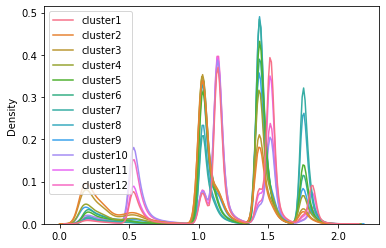

In [52]:
sns.kdeplot(data=train[cluster_cols])

- So this is suggesting that the following clusters are correlated:
    - 1 & 3
    - 4 & 6
    - 5 & 8
    - 7 & 2
- In [mottchan](https://www.kaggle.com/motchan/tps-oct-2021-kmeans)'s notebook (which I'm following), he opts to add 8 new features on the basis of these: for each pair, there's one feature that divides the first by the second, adn another that multiplies the first by the second.
- All of these features prove more important for predicting the final figure than even `f22`.

In [59]:
def add_synthetic_features(df):
    df['new_f1'] = df['cluster1'] / df['cluster3']
    df['new_f2'] = df['cluster8'] / df['cluster5']
    df['new_f3'] = df['cluster7'] / df['cluster2']
    df['new_f4'] = df['cluster4'] / df['cluster6']
    df['new_f5'] = df['cluster1'] * df['cluster3']
    df['new_f6'] = df['cluster8'] * df['cluster5']
    df['new_f7'] = df['cluster7'] * df['cluster2']
    df['new_f8'] = df['cluster4'] * df['cluster6']
    return df

In [60]:
train = add_synthetic_features(train)

In [61]:
test = add_synthetic_features(test)

In [62]:
train.to_feather(altdatapath/'train-WITH-KMeans_8cluster_ninit50_maxiter1000_rs42-AND-synthetic.feather')
test.to_feather(altdatapath/'test-WITH-KMeans_8cluster_ninit50_maxiter1000_rs42-AND-synthetic.feather')

# (old) ↓

In [20]:
low_cardinality_features = [{f: len(X[f].unique())} for f in X.columns if len(X[f].unique()) < 100000]
low_cardinality_features

[{'f265': 2},
 {'f255': 2},
 {'f22': 2},
 {'f117': 75104},
 {'f256': 2},
 {'f103': 76473},
 {'f260': 2},
 {'f252': 2},
 {'f247': 2},
 {'f274': 2},
 {'f243': 2},
 {'f108': 66767},
 {'f210': 65746},
 {'f43': 2},
 {'f258': 2},
 {'f266': 2},
 {'f269': 2},
 {'f245': 2},
 {'f99': 86896}]

In [21]:
higher_cardinality_features = [{f: len(X[f].unique())} for f in X.columns if len(X[f].unique()) > 100000]
higher_cardinality_features

[{'f174': 542053},
 {'f72': 573057},
 {'f44': 241770},
 {'f53': 240013},
 {'f62': 332336},
 {'f16': 313228},
 {'f206': 431717},
 {'f74': 175223},
 {'f33': 324185},
 {'f143': 444524},
 {'f6': 421827},
 {'f169': 606385},
 {'f29': 132977},
 {'f208': 365225},
 {'f107': 147096},
 {'f71': 125690},
 {'f152': 399983},
 {'f90': 426170},
 {'f18': 163185},
 {'f56': 225538},
 {'f77': 322750},
 {'f4': 401939},
 {'f5': 241585},
 {'f87': 198478},
 {'f129': 183006},
 {'f7': 265619},
 {'f58': 482130},
 {'f187': 188558},
 {'f3': 244851},
 {'f225': 558377},
 {'f229': 358098},
 {'f20': 226437},
 {'f211': 223364},
 {'f70': 157423},
 {'f199': 302838},
 {'f61': 268732},
 {'f118': 189040},
 {'f144': 607935},
 {'f93': 410485},
 {'f130': 352035},
 {'f128': 177314},
 {'f27': 223306},
 {'f1': 374634},
 {'f85': 325589},
 {'f212': 216199},
 {'f80': 140510},
 {'f86': 365382},
 {'f76': 212732},
 {'f200': 420271},
 {'f64': 132128},
 {'f83': 202494},
 {'f127': 226315},
 {'f138': 497263},
 {'f11': 141980},
 {'f19': 1613

In [22]:
# for f in X.columns:
#     pct_diff = (1000000 - X[f].nunique()) / 1000000
#     if pct_diff >= 0.9:
#         print(f"for {f}: {pct_diff}")
    
    

In [23]:
# for f in X.columns:
#     pct_diff = (1000000 - X[f].nunique()) / 1000000
#     if pct_diff >= 0.8:
#         print(f"for {f}: {pct_diff}")

In [24]:
categoricals = [f for f in X.columns if ((1000000 - X[f].nunique()) / 1000000) >=0.9]

In [25]:
import category_encoders as ce

In [26]:
# encoder = ce.woe.WOEEncoder(cols=categoricals)

In [27]:
# encoder.fit(X,y)

In [28]:
# X_woe = encoder.transform(X)

In [29]:
# type(X_woe)

In [30]:
# X_woe.head()

In [31]:
def baseline_test(X,y):
    best_xgboost_params = {
        'n_estimators': 3878,
        'max_depth': 4,
        'learning_rate': 0.024785857161974977,
        'reg_alpha': 26.867682044658245,
        'reg_lambda': 10.839759074147148,
        'subsample': 0.8208581489835881,
        'min_child_weight': 8.829122644339664,
        'colsample_bytree': 0.906420714280384,
        'gamma': 1.472322916021486
    }

    # instantiate the model, with some parameters locked in, and experimnental ones passed via splat 
    model = XGBClassifier(
        objective='binary:logistic',
        verbosity=1,
        tree_method='gpu_hist',
        booster='gbtree', # not bothering with dart for time reasons
        random_state=SEED,
        **best_xgboost_params
    #         n_jobs=-1,
    #         **params
    )    
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=int(SEED), shuffle=True)

    model.fit(X_train, y_train)
    
    # generate predictions
    preds = model.predict_proba(X_valid)[:,1]
    # rounds to the nearest integer, and the nearest even in case of _.5s

    # Evaluation
    valid_auc = roc_auc_score(y_valid, preds)
    print('ROC AUC Score of XGBoost =', valid_auc)
    return valid_auc

The best parametece.sum_codingto present have been:

```python
best_xgboost_params = {
        'n_estimators': 3878,
        'max_depth': 4,
        'learning_rate': 0.024785857161974977,
        'reg_alpha': 26.867682044658245,
        'reg_lambda': 10.839759074147148,
        'subsample': 0.8208581489835881,
        'min_child_weight': 8.829122644339664,
        'colsample_bytree': 0.906420714280384,
        'gamma': 1.472322916021486
    }
```

These params get the following ROC_AUC scores on a 20% holdout for these dataset versions:

| Version | Feature Count | category_encoder | Valid ROC-AUC |
| ----- | ----- | ----- | ----- |
| original | 285 | none | 0.8572984856383443 |
| Boruta green-only | 98 | none | 0.8553163413048461 |
| Boruta green-and-blue | 109 | none | 0.8558487581638441 |
| Boruta with SHAP | 136 | none | 0.8566790062778752 |
| Boruta with SHAP | 136 | woe | 0.8899772033406148 |
| original | 285 | woe | 0.8903361849466815 |

So, Boruta with SHAP performs better than Boruta with green-only *and* Boruta with green and blue, landing 0.8566790062778752

So, boruta with green only gets 0.8553163413048461, vs 0.8572984856383443 for the same model on the vanilla training set. Not bad.

Let's try a more conservative take -- the green zone *plus* the blue zone (i.e. the take-it-or-leave-it features).

In [32]:
# baseline_test(X_woe, y)

In [33]:
# X = pd.read_feather(datapath/'train.feather').iloc[:, :-1]

In [34]:
X.shape

(1000000, 136)

In [35]:
# encoder.fit(X,y)

In [36]:
# X_woe_orig = encoder.transform(X)

In [37]:
# baseline_test(X_woe_orig,y)

In [38]:
# X_woe.to_feather(path=altdatapath/'X_boruta_SHAP_woe.feather')

In [39]:
# X_woe_orig.to_feather(path=altdatapath/'X_orig_woe.feather')

In [40]:
# del X_woe, X_woe_orig

In [41]:
encoders = [
#     ce.SumEncoder(cols=categoricals),
#     ce.BackwardDifferenceEncoder(cols=categoricals),
    ce.CatBoostEncoder(cols=categoricals), # best yet, > 0.89
    ce.CountEncoder(cols=categoricals), #  pretty weak, ~0.855
#     ce.GLMMEncoder(cols=categoricals),
#     ce.HelmertEncoder(cols=categoricals),
#     ce.JamesSteinEncoder(cols=categoricals),
#     ce.LeaveOneOutEncoder(cols=categoricals),
#     ce.MEstimateEncoder(cols=categoricals),
#     ce.OrdinalEncoder(cols=categoricals),
#     ce.PolynomialEncoder(cols=categoricals),
    ce.TargetEncoder(cols=categoricals),   
]

In [42]:
# train_source = altdatapath/'X_boruta_shap_200trials.feather'
# del X 
# X = pd.read_feather(train_source)

In [43]:
for encoder in encoders:
    print(f"Testing {str(encoder)}")
    encoder.fit(X,y)
    X_enc = encoder.transform(X)
    baseline_test(X_enc,y)
    del X_enc

Testing CatBoostEncoder(cols=['f265', 'f255', 'f22', 'f117', 'f256', 'f103', 'f260',
                      'f252', 'f247', 'f274', 'f243', 'f108', 'f210', 'f43',
                      'f258', 'f266', 'f269', 'f245', 'f99'])
[17:02:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC AUC Score of XGBoost = 0.8910374882085335
Testing CountEncoder(cols=['f265', 'f255', 'f22', 'f117', 'f256', 'f103', 'f260',
                   'f252', 'f247', 'f274', 'f243', 'f108', 'f210', 'f43',
                   'f258', 'f266', 'f269', 'f245', 'f99'],
             combine_min_nan_groups=True)
[17:05:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd lik

# Experiment setup

In [15]:
# wandb_kwargs = {
#     # wandb config:
#     'name': f"{os.environ['WANDB_NOTEBOOK_NAME'][:-6]}_{datetime.now().strftime('%H%M%S')}", # just removes the .ipynb extension, leaving the notebook filename's stem
#     'project': '202109_Kaggle_tabular_playground',
#     'tags': ['sweep'],
#     'notes': "Sweep for CatBoost using Optuna",
#     'config': exmodel_config,
# }

In [16]:
X.shape

(1000000, 285)

In [17]:
# X_test.shape

In [18]:
# X_test.head()

In [19]:
# feature_picker = XGBClassifier(
#     verbosity = 1,
#     tree_method = 'gpu_hist',
#     booster = 'gbtree',
#     random_state = SEED
# )

feature_picker = CatBoostClassifier(task_type='GPU', silent=True, random_state=SEED)

In [20]:
boruta = BorutaShap(model=feature_picker,
                    importance_measure='shap',
                    classification=True)
#     verbose=True,
# #     random_state=SEED,
#     estimator=feature_picker,
#     n_estimators='auto',
#     max_iter=200,
# )

In [21]:
boruta.fit(X=X, y=y, n_trials=200, sample=False, train_or_test='train', normalize=False, verbose=True, random_state=SEED, stratify=False)
# boruta = load('/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/alt_datasets/boruta_200iter.joblib')

  0%|          | 0/200 [00:00<?, ?it/s]

136 attributes confirmed important: ['f174', 'f72', 'f265', 'f44', 'f53', 'f62', 'f16', 'f206', 'f74', 'f33', 'f143', 'f6', 'f169', 'f29', 'f255', 'f208', 'f107', 'f71', 'f152', 'f90', 'f22', 'f18', 'f56', 'f77', 'f4', 'f5', 'f87', 'f129', 'f117', 'f7', 'f58', 'f256', 'f187', 'f103', 'f3', 'f225', 'f229', 'f20', 'f211', 'f260', 'f70', 'f199', 'f61', 'f118', 'f144', 'f93', 'f130', 'f128', 'f27', 'f1', 'f85', 'f212', 'f252', 'f80', 'f86', 'f76', 'f200', 'f64', 'f83', 'f127', 'f138', 'f11', 'f19', 'f82', 'f231', 'f247', 'f239', 'f60', 'f119', 'f42', 'f2', 'f75', 'f79', 'f214', 'f73', 'f92', 'f40', 'f156', 'f157', 'f147', 'f226', 'f52', 'f98', 'f179', 'f274', 'f173', 'f112', 'f140', 'f89', 'f141', 'f65', 'f195', 'f192', 'f14', 'f139', 'f78', 'f222', 'f184', 'f163', 'f114', 'f96', 'f243', 'f108', 'f154', 'f35', 'f133', 'f241', 'f55', 'f210', 'f8', 'f17', 'f48', 'f191', 'f12', 'f63', 'f69', 'f26', 'f162', 'f43', 'f213', 'f238', 'f258', 'f150', 'f266', 'f13', 'f136', 'f201', 'f113', 'f134', '

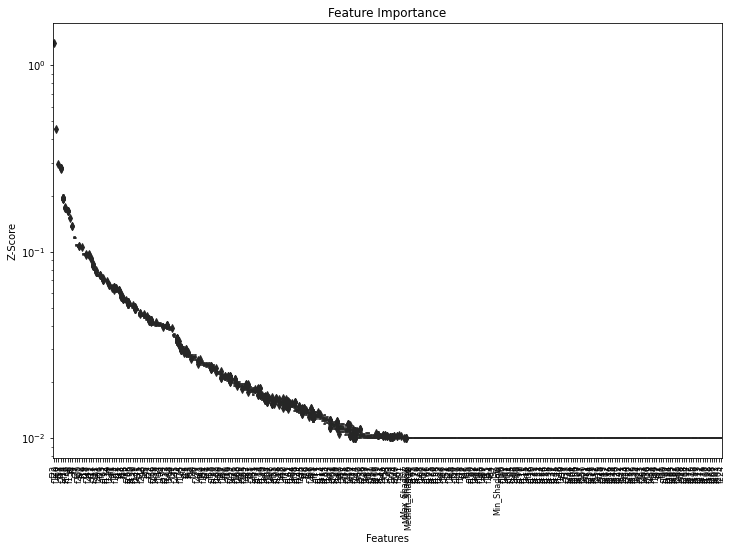

In [22]:
boruta.plot(which_features='all')

In [23]:
X_boruta_shap = boruta.Subset()

In [ ]:
# green_zone = X.columns[boruta.support_].to_list()
# blue_zone = X.columns[boruta.support_weak_].to_list()

In [ ]:
# feature_ranks = boruta.ranking_

In [ ]:
# X_filtered = boruta.transform(np.array(X))

In [24]:
dump(X_boruta_shap, filename=altdatapath/'X_boruta_shap_200trials.joblib')
dump(boruta, filename=altdatapath/'boruta_shap.joblib')

['/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/alt_datasets/boruta_shap.joblib']

In [25]:
type(X_boruta_shap)

pandas.core.frame.DataFrame

In [28]:
X_boruta_shap.index.name = None

In [29]:
X_boruta_shap.to_feather(path=altdatapath/'X_boruta_shap_200trials.feather')

In [30]:
X_boruta_shap.head()

,f174,f72,f265,f44,f53,f62,f16,f206,f74,f33,...,f201,f113,f134,f269,f245,f95,f227,f125,f99,f164
0,0.010250,0.004855,0,0.193430,0.192042,0.519336,0.341702,0.011936,0.257688,0.034818,...,0.216079,0.087502,0.217984,1,1,0.559151,0.011277,0.003969,0.112203,0.407014
1,0.005768,0.004312,0,0.821982,0.224053,0.447242,0.459358,0.011285,0.415982,0.033018,...,0.240681,0.084309,0.222525,0,0,0.145737,0.011031,0.004784,0.111834,0.090468
2,0.012026,0.004507,0,0.162094,0.239486,0.749593,0.257763,0.009230,0.274105,0.035977,...,0.163251,0.085933,0.224012,0,1,0.144596,0.009546,0.003502,0.110486,0.090032
3,0.011034,0.002806,0,0.834834,0.175250,0.605277,0.335907,0.007412,0.260443,0.319312,...,0.163644,0.085584,0.248067,0,1,0.146811,0.006251,0.008915,0.361132,0.091527
4,0.008832,0.004219,1,0.844187,0.249345,0.415167,0.319548,0.013731,0.215576,0.034490,...,0.233770,0.083699,0.219750,0,1,0.148517,0.006527,0.005913,0.113454,0.092484


In [ ]:
# dump(boruta, '/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/alt_datasets/boruta_200iter.joblib')

In [ ]:
# len(green_zone)

In [ ]:
# len(blue_zone)

In [ ]:
# X_filtered.shape

In [ ]:
# feature_ranks

In [ ]:
# type(X)

In [ ]:
# y_np = np.array(y)

In [ ]:
# del y

In [ ]:
# type(X_filtered), type(y_np)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X_boruta_shap, np.array(y), test_size=0.2, random_state=int(SEED), shuffle=True)

model.fit(X_train, y_train)

[08:52:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.906420714280384,
              gamma=1.472322916021486, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.024785857161974977,
              max_delta_step=0, max_depth=4, min_child_weight=8.829122644339664,
              missing=nan, monotone_constraints='()', n_estimators=3878,
              n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=26.867682044658245, reg_lambda=10.839759074147148,
              scale_pos_weight=1, subsample=0.8208581489835881,
              tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [33]:
# generate predictions
preds = model.predict_proba(X_valid)[:,1]
# rounds to the nearest integer, and the nearest even in case of _.5s

# Evaluation
valid_auc = roc_auc_score(y_valid, preds)
print('ROC AUC Score of XGBoost =', valid_auc) # was 0.7783978025549229 for pca_poly; 0.8572984856383443 for vanilla

ROC AUC Score of XGBoost = 0.8566790062778752


In [43]:
del X_train, X_valid 

In [51]:
X_boruta_blue_green = np.concatenate((X_filtered, np.array(X[blue_zone])), axis=1)

In [52]:
X_boruta_blue_green.shape

(1000000, 109)

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X_boruta_blue_green, y_np, test_size=0.2, random_state=int(SEED), shuffle=True)

model.fit(X_train, y_train)
# generate predictions
preds = model.predict_proba(X_valid)[:,1]
# rounds to the nearest integer, and the nearest even in case of _.5s

# Evaluation
valid_auc = roc_auc_score(y_valid, preds)
print('ROC AUC Score of XGBoost =', valid_auc) 

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:52:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC AUC Score of XGBoost = 0.8558487581638441


So Boruta with green and blue gets 0.8558487581638441 -- a bit better than the green-zone only. Now, let's try adding polynomial features.

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_boruta_blue_green_poly = poly.fit_transform(X_boruta_blue_green)

In [ ]:
dump(X_boruta_blue_green, '/media/sf/easystore/kaggle_data/tabular_playgrounds/oct2021/alt_datasets/X_boruta_200iter_green+blue_109features.joblib')
del X_boruta_blue_green

In [32]:
del X_pca_poly

In [33]:
train_source = datapath/'train.feather'
df = pd.read_feather(path=train_source)
df.index.name = 'id'
y = df.target
features = [x for x in df.columns if x != 'target']
X = df[features]
# X.index.name = 'id'
# y.index.name = 'id'
# X = np.array(X_train)
# y = np.array(y_train)

# del df, X_train, y_train


# exmodel_config['feature_count'] = len(X.columns)
# exmodel_config['feature_count'] = X.shape[1]
# exmodel_config['instance_count'] = X.shape[0]

# exmodel_config['feature_generator'] = None
# exmodel_config['feature_generator'] = "Summary statistics"

# exmodel_config['train_source'] = str(train_source)
test_source = datapath/'test.feather'
# exmodel_config['test_source'] = str(test_source)
X_test = pd.read_feather(path=test_source)
X_test = X_test.iloc[:, 1:]
# X_test = np.array(X_test)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_np, test_size=0.2, random_state=int(SEED), shuffle=True)

model.fit(X_train, y_train)

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.906420714280384,
              gamma=1.472322916021486, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.024785857161974977,
              max_delta_step=0, max_depth=4, min_child_weight=8.829122644339664,
              missing=nan, monotone_constraints='()', n_estimators=3878,
              n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=26.867682044658245, reg_lambda=10.839759074147148,
              scale_pos_weight=1, subsample=0.8208581489835881,
              tree_method='gpu_hist', validate_parameters=1, verbosity=1)

In [35]:
# generate predictions
preds = model.predict_proba(X_valid)[:,1]
# rounds to the nearest integer, and the nearest even in case of _.5s

# Evaluation
valid_auc = roc_auc_score(y_valid, preds)
print('ROC AUC Score of XGBoost =', valid_auc)

ROC AUC Score of XGBoost = 0.8572984856383443


In [14]:
# originally from https://www.kaggle.com/satorushibata/optimize-catboost-hyperparameter-with-optuna-gpu
def objective(trial):
    # split the (original Kaggle training) data into partitions
    # if study.best_trial:
    #     print("Dumping best params, which are:")
    #     print(str(study.best_trial.params))
    #     dump(study.best_trial.params, filename=datapath/'optuna_catboost_best_20210920.joblib')
    
#     pca_components = trial.suggest_int('pca_components', 50, 285)
    pca = PCA(n_components=pca_components, random_state=42)
    X_pca = pca.fit_transform(X)
#     dump(pca60, edapath/'PCA_60.joblibg')
    
    # else:
    #     print("No best study yet")
    X_train, X_valid, y_train, y_valid = train_test_split(X_pca, y, test_size=0.33, random_state=int(SEED), shuffle=True)
    # create wrappers for the training and validation partitions
    # train_pool = catboost.Pool(X_train, y_train)
    # valid_pool = catboost.Pool(X_valid, y_valid)
    
    # experimental parameters
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 900, 6000), # was 900-4500 for CPU
#         'max_depth' : trial.suggest_int('depth', 3, 10),                                       
#         'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.4),               
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.001, 30),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.001, 30),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1),
# #         'booster': trial.suggest_categorical('boosting_type', ['gbtree', 'dart']),
#         'min_child_weight': trial.suggest_uniform('min_child_weight', 0.001, 10),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
#         'gamma': trial.suggest_uniform('gamma', 0.1, 30)
#     }  

    best_xgboost_params = {
        'n_estimators': 3878,
        'max_depth': 4,
        'learning_rate': 0.024785857161974977,
        'reg_alpha': 26.867682044658245,
        'reg_lambda': 10.839759074147148,
        'subsample': 0.8208581489835881,
        'min_child_weight': 8.829122644339664,
        'colsample_bytree': 0.906420714280384,
        'gamma': 1.472322916021486
    }

    # instantiate the model, with some parameters locked in, and experimnental ones passed via splat 
    model = XGBClassifier(
        objective='binary:logistic',
        verbosity=1,
        tree_method='gpu_hist',
        booster='gbtree', # not bothering with dart for time reasons
        random_state=SEED,
        **best_xgboost_params
#         n_jobs=-1,
#         **params
    )    

    model.fit(X_train, y_train)
    # generate predictions
    preds = model.predict_proba(X_valid)[:,1]
    # rounds to the nearest integer, and the nearest even in case of _.5s

    # Evaluation
    valid_auc = roc_auc_score(y_valid, preds)
    print('ROC AUC Score of XGBoost =', valid_auc)
    wandb.log({'valid_auc': valid_auc,
              })

    return valid_auc

In [15]:
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

<ipython-input-15-69ea9289a2cf>:1: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find sweep_xgboost_20211010.ipynb
wandb: Currently logged in as: hushifang (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [16]:
study = optuna.create_study(direction = "maximize", 
                            sampler = TPESampler(seed=int(SEED)), 
                            study_name=f"pca_{datetime.now().strftime('%Y%m%d')}")

# study = load(studypath/f"optuna_xgboost_study_106trials_20211004.joblib")


[I 2021-10-10 11:57:06,723] A new study created in memory with name: pca_20211010


In [17]:
import torch

In [18]:
import xgboost

In [19]:
xgboost.core.XGBoostError?

Init signature: xgboost.core.XGBoostError(self, /, *args, **kwargs)
Docstring:      Error thrown by xgboost trainer.
File:           ~/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/core.py
Type:           type
Subclasses:     


In [20]:
for x in range(1,200):
    study.optimize(objective, n_trials = 1, callbacks = [wandbc], show_progress_bar=True, catch=(xgboost.core.XGBoostError,)) 
    dump(study, filename=datapath/f"optuna_dataset-pca_study_{x}trials_{datetime.now().strftime('%Y%m%d')}.joblib")
#     dump(study.best_trial.params, filename=datapath/f'optuna_lightgbm_study_best-thru-{x*5}trials_20210927.joblib')

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:57:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 0 < 1; dropping {'pca_components': 138, 'value': 0.8283967087232865}.


ROC AUC Score of XGBoost = 0.8283967087232865
[I 2021-10-10 11:59:12,446] Trial 0 finished with value: 0.8283967087232865 and parameters: {'pca_components': 138}. Best is trial 0 with value: 0.8283967087232865.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:59:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 1 < 2; dropping {'pca_components': 274, 'value': 0.8472107426301871}.


ROC AUC Score of XGBoost = 0.8472107426301871
[I 2021-10-10 12:02:45,979] Trial 1 finished with value: 0.8472107426301871 and parameters: {'pca_components': 274}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:03:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 2 < 3; dropping {'pca_components': 222, 'value': 0.8411313966895685}.


ROC AUC Score of XGBoost = 0.8411313966895685
[I 2021-10-10 12:06:07,082] Trial 2 finished with value: 0.8411313966895685 and parameters: {'pca_components': 222}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:06:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 3 < 4; dropping {'pca_components': 191, 'value': 0.8342598041011918}.


ROC AUC Score of XGBoost = 0.8342598041011918
[I 2021-10-10 12:09:03,422] Trial 3 finished with value: 0.8342598041011918 and parameters: {'pca_components': 191}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:09:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 4 < 5; dropping {'pca_components': 86, 'value': 0.806690388517508}.


ROC AUC Score of XGBoost = 0.806690388517508
[I 2021-10-10 12:10:25,360] Trial 4 finished with value: 0.806690388517508 and parameters: {'pca_components': 86}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:10:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 5 < 6; dropping {'pca_components': 86, 'value': 0.806690388517508}.


ROC AUC Score of XGBoost = 0.806690388517508
[I 2021-10-10 12:11:46,686] Trial 5 finished with value: 0.806690388517508 and parameters: {'pca_components': 86}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 6 < 7; dropping {'pca_components': 63, 'value': 0.7904181686815366}.


ROC AUC Score of XGBoost = 0.7904181686815366
[I 2021-10-10 12:12:47,694] Trial 6 finished with value: 0.7904181686815366 and parameters: {'pca_components': 63}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:13:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 7 < 8; dropping {'pca_components': 254, 'value': 0.8452885185751505}.


ROC AUC Score of XGBoost = 0.8452885185751505
[I 2021-10-10 12:15:43,607] Trial 7 finished with value: 0.8452885185751505 and parameters: {'pca_components': 254}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 8 < 9; dropping {'pca_components': 191, 'value': 0.8342598041011918}.


ROC AUC Score of XGBoost = 0.8342598041011918
[I 2021-10-10 12:18:38,689] Trial 8 finished with value: 0.8342598041011918 and parameters: {'pca_components': 191}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 9 < 10; dropping {'pca_components': 217, 'value': 0.8409412517853502}.


ROC AUC Score of XGBoost = 0.8409412517853502
[I 2021-10-10 12:21:58,921] Trial 9 finished with value: 0.8409412517853502 and parameters: {'pca_components': 217}. Best is trial 1 with value: 0.8472107426301871.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 10 < 11; dropping {'pca_components': 281, 'value': 0.8474176983005992}.


ROC AUC Score of XGBoost = 0.8474176983005992
[I 2021-10-10 12:25:32,672] Trial 10 finished with value: 0.8474176983005992 and parameters: {'pca_components': 281}. Best is trial 10 with value: 0.8474176983005992.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 11 < 12; dropping {'pca_components': 270, 'value': 0.8462401528718595}.


ROC AUC Score of XGBoost = 0.8462401528718595
[I 2021-10-10 12:29:05,642] Trial 11 finished with value: 0.8462401528718595 and parameters: {'pca_components': 270}. Best is trial 10 with value: 0.8474176983005992.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:29:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 12 < 13; dropping {'pca_components': 278, 'value': 0.8472224222376469}.


ROC AUC Score of XGBoost = 0.8472224222376469
[I 2021-10-10 12:32:39,229] Trial 12 finished with value: 0.8472224222376469 and parameters: {'pca_components': 278}. Best is trial 10 with value: 0.8474176983005992.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:32:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 13 < 14; dropping {'pca_components': 239, 'value': 0.8446363408619656}.


ROC AUC Score of XGBoost = 0.8446363408619656
[I 2021-10-10 12:35:35,341] Trial 13 finished with value: 0.8446363408619656 and parameters: {'pca_components': 239}. Best is trial 10 with value: 0.8474176983005992.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:35:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


wandb: WARNING Step must only increase in log calls.  Step 14 < 15; dropping {'pca_components': 283, 'value': 0.8474194357944366}.


ROC AUC Score of XGBoost = 0.8474194357944366
[I 2021-10-10 12:39:09,826] Trial 14 finished with value: 0.8474194357944366 and parameters: {'pca_components': 283}. Best is trial 14 with value: 0.8474194357944366.


/home/sf/anaconda3/envs/tabular-x/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# dump(study, filename=datapath/f"optuna_xgboost_100trials-complete_{datetime.now().strftime('%Y%m%d')}.joblib")
# dump(study.best_trial.params, filename=datapath/f"optuna_lightgbm_all-500trials-best_{datetime.now().strftime('%Y%m%d')}.joblib")
# pickle.dump(study.best_trial.params, open('CatBoost_Hyperparameter.pickle', 'wb'))
# print('CatBoost Hyperparameter:', study.best_trial.params)

In [ ]:
study.best_trial.params

In [ ]:
wandb.log({'xgboost_params': study.best_trial.params})
wandb.finish()

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)